In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from datetime import datetime, timedelta
import cmocean

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow.python.keras.optimizer_v2.adam import Adam
tfd = tfp.distributions
import tensorflow.keras.backend as K
from tensorflow import math as tfm

import os

import utilsProb
import utilsProbSS
import glob
import sys
from scipy.stats import rankdata
import pandas as pd
import importlib
import copy
from netCDF4 import Dataset, num2date
from scipy.interpolate import interpn
from matplotlib.colors import Normalize 
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context("paper")
import properscoring as ps
from math import erf
import xarray as xr

import matplotlib
#mapping
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import Unet_b
import utils_CNN
from tensorflow.python.client import device_lib
import xarray as xr

import coms
import utilsAnEn
import utils_verif
import comsnn
from sklearn.metrics import brier_score_loss
from tqdm import tqdm

import sklearn

from statsmodels.tsa.stattools import acf, pacf, acovf
import warnings
from scipy import stats

/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def f_emp(ens,x):
    xs,ys = ecdf(ens)
    vals=[]
    vals = np.zeros([len(x)])
    for bb,xT in enumerate(x):
        if all(xs>xT):
            vals[bb] = 0
        elif (np.sum(1*(xs>xT))>0) & (np.sum(1*(xs>xT))<len(xs)):
            inds = np.searchsorted(xs>xT, 0.5)
            vals[bb] =ys[inds-1]
        else:
            vals[bb] = 1
    return np.array(vals)

def f_emp2(ens,x):
    xs,ys = ecdf(ens)
    dogs = np.searchsorted(xs,x,side='right')
    vals =ys[dogs-1]
    vals[dogs==0]=0
    return np.array(vals)

### computation of threshold-weighted CRPS via numerical approximation suggested by Gneiting & Ranjan (2011)
def twcrps_sample(y,ens,weight,thr,step_width=0.001):
    #y = real-valued observation (numpy array)
    #ens = vector of ensemble forecasts (numpy array)
    #thr = threshold parameter for weight function
    # weight = charactor vector identifying the employed weight function:
    #     "indicator.right": Indicator weight function for right tail
    #     "indicator.left": Indicator weight function for left tail
    #     "normalCDF.right": Gaussian weight function for right tail, mean = thr, and sd = 1
    #     "normalCDF.left": Gaussian weight function for right tail, mean = thr, and sd = 1
    # lower, upper: bounds for interval of evaluation points
    # step.width: increment of the sequence of evaluation points

    lower = np.min(np.append(ens,y))
    upper = np.max(np.append(ens,y))
    eval_z = np.arange(lower,upper,step_width)
    if weight not in ['indicator.right','indicator.left','normalCDF.right','normalCDF.left']:
        raise ValueError("weight function not specified correctly")
        
    if weight =='indicator.right':
        def w(z):return z>=thr
    elif weight =='indicator.left':
        def w(z):return z<=thr
    elif weight == 'normalCDF.right':
        def w(z):return stats.norm.cdf(z, loc=thr, scale=1)
    elif weight == 'normalCDF.left':
        def w(z):return 1-stats.norm.cdf(z, loc=thr, scale=1)
#     print((f_emp(ens,eval_z).shape))
    out = np.sum(w(eval_z)*((f_emp(ens,eval_z)-(y<=eval_z)))**2)*(upper-lower)/len(eval_z)
    return out

### computation of threshold-weighted CRPS via numerical approximation suggested by Gneiting & Ranjan (2011)
def twcrps_sample2(y,ens,weight,thr,step_width=0.001):
    #y = real-valued observation (numpy array)
    #ens = vector of ensemble forecasts (numpy array)
    #thr = threshold parameter for weight function
    # weight = charactor vector identifying the employed weight function:
    #     "indicator.right": Indicator weight function for right tail
    #     "indicator.left": Indicator weight function for left tail
    #     "normalCDF.right": Gaussian weight function for right tail, mean = thr, and sd = 1
    #     "normalCDF.left": Gaussian weight function for right tail, mean = thr, and sd = 1
    # lower, upper: bounds for interval of evaluation points
    # step.width: increment of the sequence of evaluation points

    lower = np.min(np.append(ens,y))
    upper = np.max(np.append(ens,y))
    eval_z = np.arange(lower,upper,step_width)
    if weight not in ['indicator.right','indicator.left','normalCDF.right','normalCDF.left']:
        raise ValueError("weight function not specified correctly")
        
    if weight =='indicator.right':
        def w(z):return z>=thr
    elif weight =='indicator.left':
        def w(z):return z<=thr
    elif weight == 'normalCDF.right':
        def w(z):return stats.norm.cdf(z, loc=thr, scale=1)
    elif weight == 'normalCDF.left':
        def w(z):return 1-stats.norm.cdf(z, loc=thr, scale=1)
    
#     print(eval_z.shape)
#     print((f_emp2(ens,eval_z).shape))
    
    out = np.sum(w(eval_z)*((f_emp2(ens,eval_z)-(y<=eval_z)))**2)*(upper-lower)/len(eval_z)
    return out


def DMtest(e1,e2,h=1,power=2,alternative='two.sided'):
    d = np.abs(e1)**power - np.abs(e2)**power
    
    if h == 0:
        dcov = acovf(d,nlag=h,fft=False,missing='drop')
    else:
        dcov = acovf(d,nlag=h-1,fft=False,missing='drop')
    dvar = np.sum(np.append(dcov[0],2*dcov[1:]))/len(d)
    dv = dvar
    if dv>0:
        STATISTIC =np.nanmean(d)/np.sqrt(dv)
    elif (h==1):
        raise ValueError("Variance of DM statistic is zero")
    else: 
        warnings.warn('Variance is negative, using horizon h=1') 
        DMtest(e1,e2,h=1,power=power)   
    n = len(d)
    if h==0:
        k=1
    else:
        k = ((n + 1 - 2 * h + (h / n) * (h - 1)) / n) **(0.5)
    STATISTIC = STATISTIC *k 
    
    if alternative == 'two.sided':
        PVAL = 2*stats.t.cdf(-np.abs(STATISTIC),df=n-1)
    elif alternative == 'less':
        PVAL = stats.t.cdf(STATISTIC,df=n-1)
    elif alternative == 'greater':
        PVAL = 1-stats.t.cdf(STATISTIC,df=n-1)
        
    PARAMETER = [h,power]
    return_DICT = {"DM":STATISTIC,'forecast_horizon':h,'power':power,'p_val':PVAL,'Method':'Diebold-Mariano Test'
                  }
    return return_DICT



def bh_correction(pval,level=0.05):
    nn = len(pval)
    pv_srt = sorted(pval)
    limits = np.arange(1,nn+1)*level/nn
    
    if len(np.where(pv_srt<limits))==0:
        discoveries = 0
        return discoveries
    else:
        discoveries = np.max(np.where(pv_srt<limits))
        return discoveries/nn 
    
def fdr_threshold(pvalues, alpha=0.05):
    """Computes the FDR threshod after Wilks (2016)."""
    p = np.sort(np.asarray(pvalues).flatten())
    n = len(p)
    return np.max(np.where(p <= (np.arange(1, n+1) / n * alpha), p, 0))

## Gather the Data, Test, Plot

doing: F006
No Post-Processing
2016
2017
2018
this is the threshold: 500 for a percentile: 500
No Post-Processing
2016
2017
2018
___ ...done... Starting DM ___
[[  0.      7.846  10.615   5.854   5.259   2.608]
 [ -7.846   0.      9.119   2.543   1.84   -1.549]
 [-10.615  -9.119   0.     -6.709  -7.71  -12.002]
 [ -5.854  -2.543   6.709   0.     -2.256  -6.665]
 [ -5.259  -1.84    7.71    2.256   0.     -5.437]
 [ -2.608   1.549  12.002   6.665   5.437   0.   ]]
[[0.    0.    0.    0.    0.    0.009]
 [0.    0.    0.    0.011 0.066 0.121]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.011 0.    0.    0.024 0.   ]
 [0.    0.066 0.    0.024 0.    0.   ]
 [0.009 0.121 0.    0.    0.    0.   ]]
doing: F012
No Post-Processing
2016
2017
2018
this is the threshold: 500 for a percentile: 500
No Post-Processing
2016
2017
2018
___ ...done... Starting DM ___
[[ 0.     9.264  3.473 -2.625 -2.935 -2.497]
 [-9.264  0.    -1.284 -6.604 -6.723 -7.098]
 [-3.473  1.284  0.    -7.623 -7.834 -7.371]
 [ 

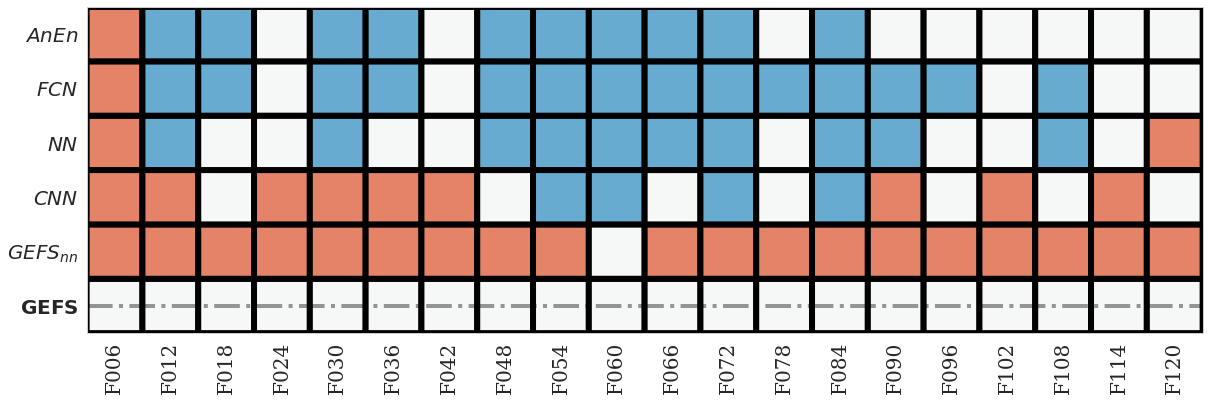

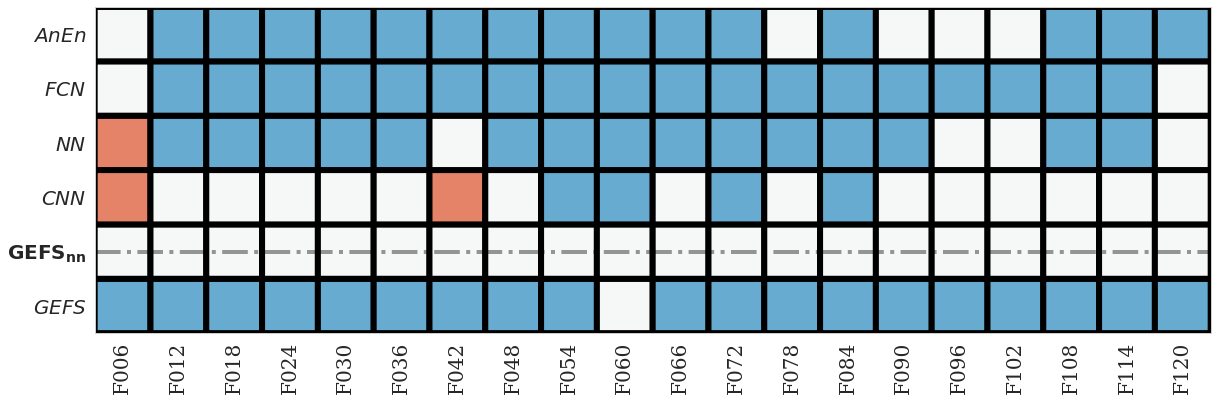

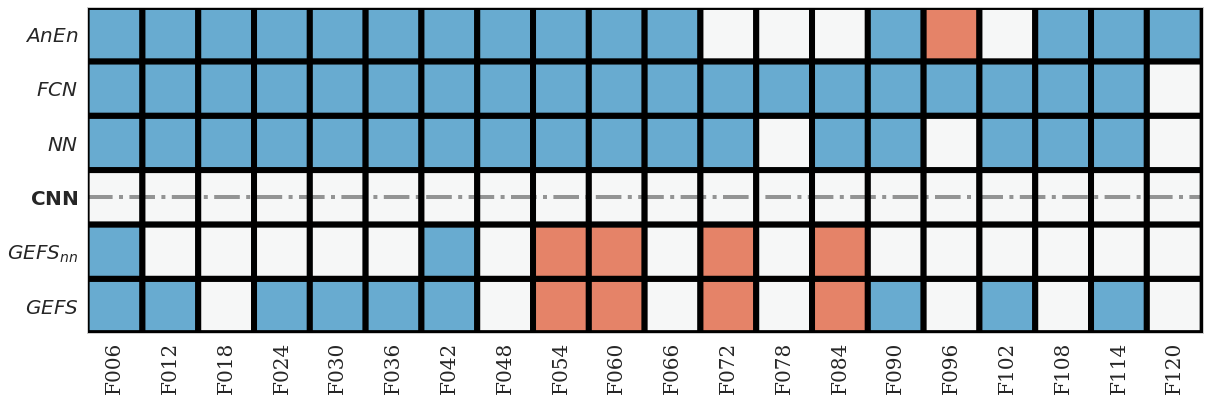

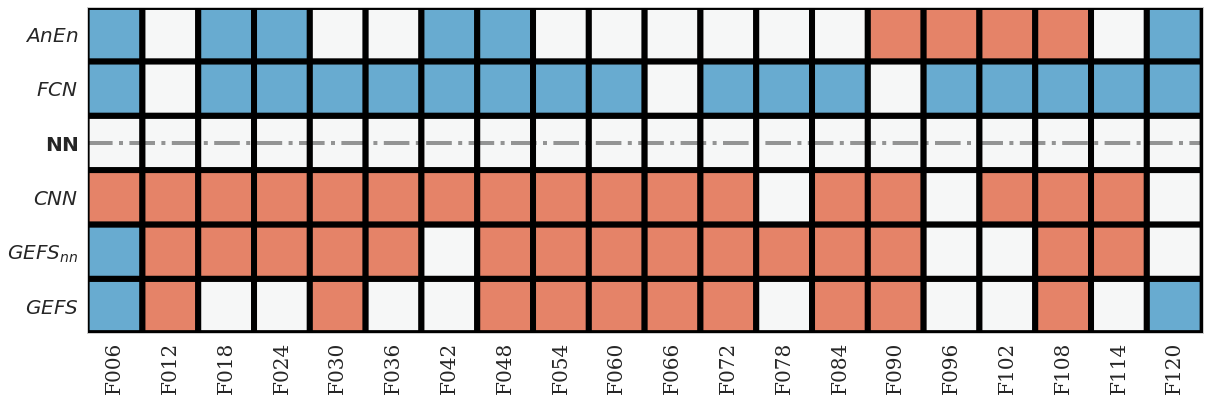

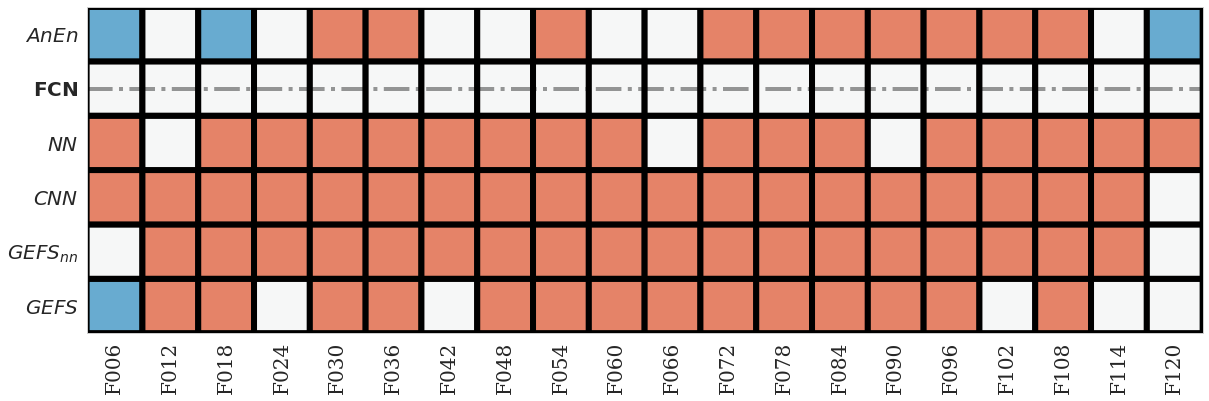

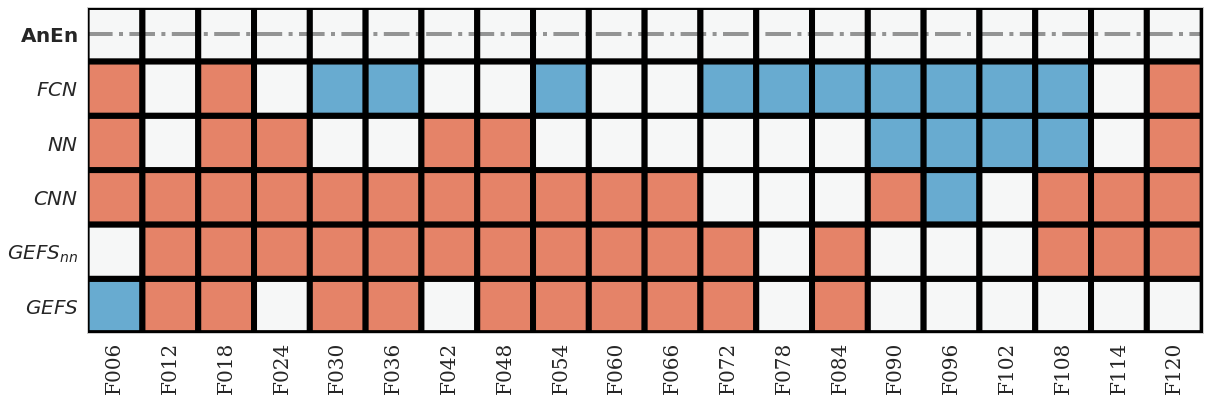

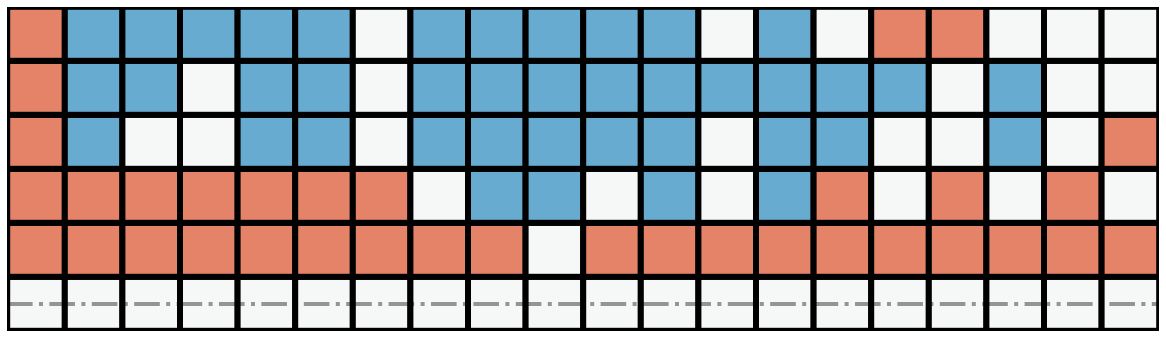

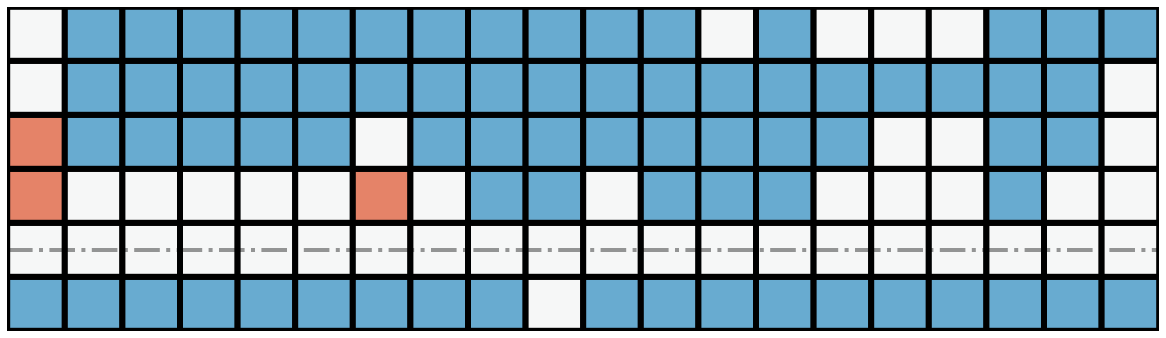

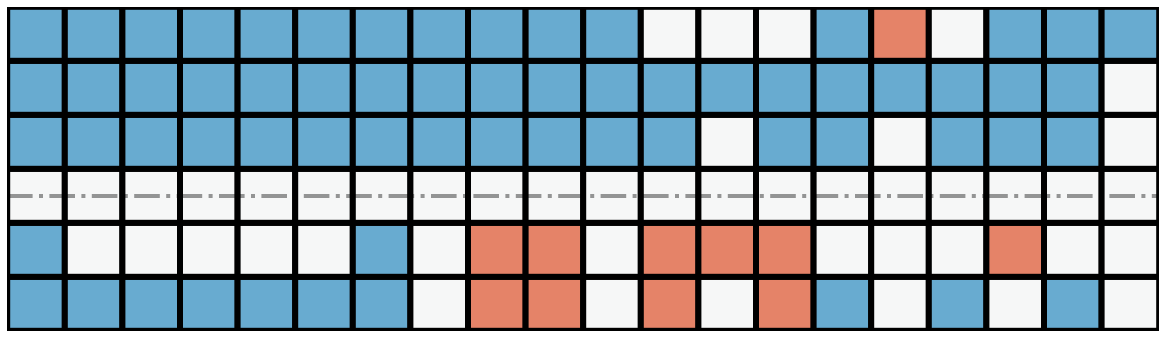

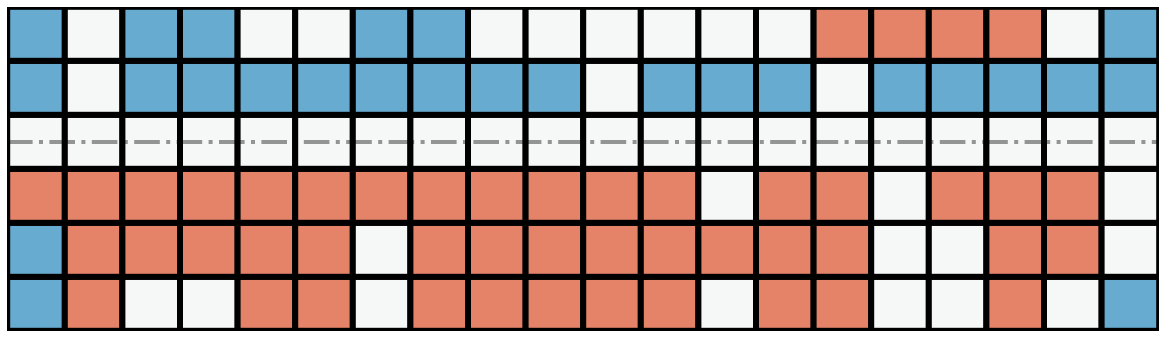

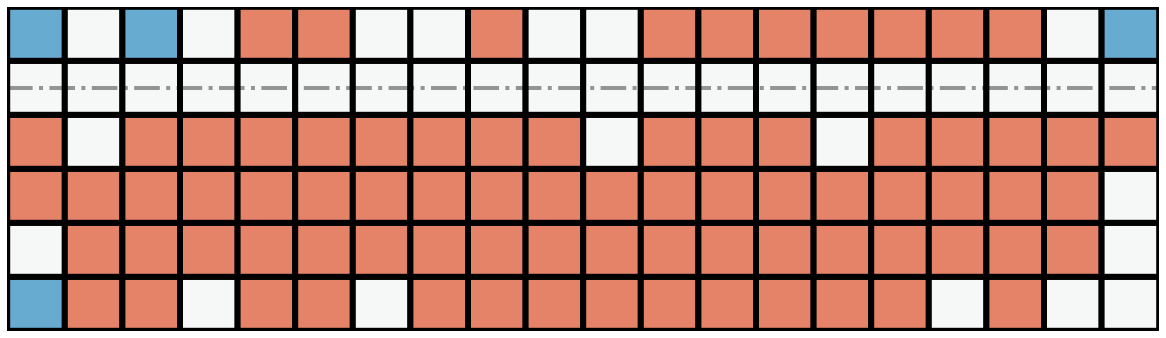

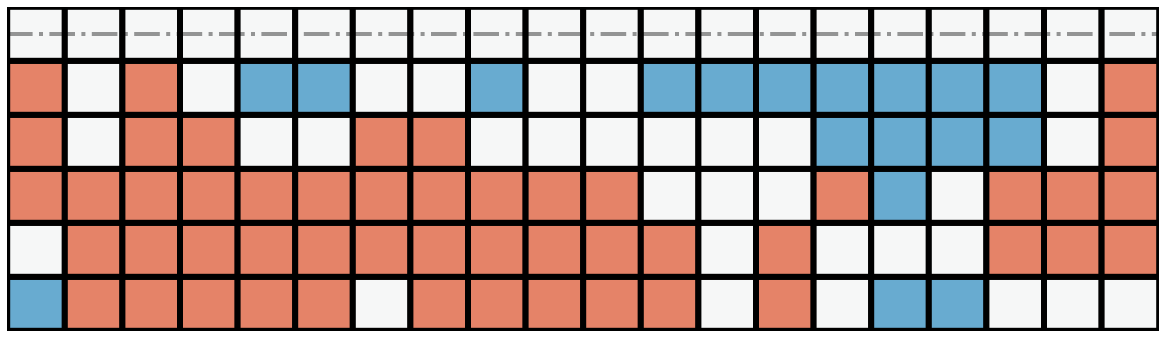

In [3]:
percys = [500]
for percy in percys:
    
    dffin=pd.DataFrame({'Lead':[],'Model':[],'CRPS':[]})
    fcasts = ['F'+f'{bb:03}' for bb in np.arange(6,126,6)]
    ense = 100
    DMs_tot=np.zeros([len(fcasts),6,6])
    DMp_tot=np.zeros([len(fcasts),6,6])
    for intd, fcast in enumerate(fcasts):
        print('doing:',fcast)
        fortts=np.array([])
        mods = ['CNNft_ref','MV_gefs','Raw_gefs','AnEn','NN_ref']
        for mod in mods:
            df,Pre_m, Pre_s, Post_m, Post_s, Obs =utils_verif.load_forecast(fcast,mod)
            fortts=np.concatenate([fortts,np.array(Post_m)])
            bounds =[]
#             threshold = np.percentile(fortts,percy)
            threshold=percy
        ##############
        print("this is the threshold:",threshold,'for a percentile:', percy)
        ########################################################################################################
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnng','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})
    
        mod = 'CNNft_ref'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast_cnn','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
        df2['lon']=df2['lon']+360
    
        mod = 'NNft_ref'
        df3,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df3 = df3.rename(columns={'OBS':'OBSnn','Model':'Reforecast_nn','IVTmean':'IVTmean_nn','IVTstd':'IVTstd_nn'})
        df3['lon']=df3['lon']+360
    
    
        mod = 'AnEn'
        df4,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df4 = df4.rename(columns={'OBS':'OBSanen','Model':'Reforecast_AnEn','IVTmean':'IVTmean_anen','IVTstd':'IVTstd_anen'})
        df4['AnEn_Mean'] = np.mean(df4.filter(regex='Analog'),axis=1)
        df4['AnEn_std'] = np.std(df4.filter(regex='Analog'),axis=1)
        df4['time']= df4['Issued_Time']+ timedelta(hours=int(fcast[-3:]))
    
        mod = 'NN_gefs'
        df5,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df5 = df5.rename(columns={'OBS':'OBSnng','Model':'Reforecast','IVTmean':'IVTmean_nngefs','IVTstd':'IVTstd_nngefs'})
        
        mod = 'EMOS'
        df6,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df6 = df6.rename(columns={'OBS':'OBSfcn','Model':'Reforecast','IVTmean':'IVTmean_fcn','IVTstd':'IVTstd_fcn'})
        df6['lon']=df6['lon']+360

        dfm = pd.merge(df1,df2,how='left')
        dfm = pd.merge(dfm,df3,how='left')
        dfm = pd.merge(dfm,df4,how='left')
        dfm = pd.merge(dfm,df5,how='left')
        dfm = pd.merge(dfm,df6,how='left')
    
    
        #define 4 groups:
        Merrag = dfm['OBSnng']
        For_ug = dfm['IVTmean_gefs']
        For_sg = dfm['IVTstd_gefs']
    
        Merranng = dfm['OBSnng']
        For_unng = dfm['IVTmean_nngefs']
        For_snng = dfm['IVTstd_nngefs']
    
        Merrac = dfm['OBScnn']
        For_uc = dfm['IVTmean_cnn']
        For_sc = dfm['IVTstd_cnn']
    
        Merran = dfm['OBSnn']
        For_un = dfm['IVTmean_nn']
        For_sn = dfm['IVTstd_nn']
    
        Merraa = dfm['OBSanen']
        For_ua = dfm['AnEn_Mean']
        For_sa = dfm['AnEn_std']
        
        Merrafcng = dfm['OBSfcn']
        For_ufcng = dfm['IVTmean_fcn']
        For_sfcng = dfm['IVTstd_fcn']
        
        
        countstats = 0 
        CRPS_gll=np.zeros([357,144])
        CRPS_nngll=np.zeros([357,144])
        CRPS_cll=np.zeros([357,144])
        CRPS_nll=np.zeros([357,144])
        CRPS_all=np.zeros([357,144])
        CRPS_fcnll=np.zeros([357,144])
        for lats in np.unique(dfm['lat']):
            for lons in np.unique(dfm['lon']):
                dftemp = dfm[(dfm['lat']==lats)&(dfm['lon']==lons)]
                countstats+=1
                if dftemp.shape[0] == 0:
                    countstats-=1
                    continue
            
                 #define 4 groups:
                Merrag = dftemp['OBSnng'].reset_index(drop=True)
                For_ug = dftemp['IVTmean_gefs'].reset_index(drop=True)
                For_sg = dftemp['IVTstd_gefs'].reset_index(drop=True)
    
                Merranng = dftemp['OBSnng'].reset_index(drop=True)
                For_unng = dftemp['IVTmean_nngefs'].reset_index(drop=True)
                For_snng = dftemp['IVTstd_nngefs'].reset_index(drop=True)
    
                Merrac = dftemp['OBScnn'].reset_index(drop=True)
                For_uc = dftemp['IVTmean_cnn'].reset_index(drop=True)
                For_sc = dftemp['IVTstd_cnn'].reset_index(drop=True)
    
                Merran = dftemp['OBSnn'].reset_index(drop=True)
                For_un = dftemp['IVTmean_nn'].reset_index(drop=True)
                For_sn = dftemp['IVTstd_nn'].reset_index(drop=True)
    
                Merraa = dftemp['OBSanen'].reset_index(drop=True)
                For_ua = dftemp['AnEn_Mean'].reset_index(drop=True)
                For_sa = dftemp['AnEn_std'].reset_index(drop=True)
        
                Merrafcn = dftemp['OBSfcn'].reset_index(drop=True)
                For_ufcn = dftemp['IVTmean_fcn'].reset_index(drop=True)
                For_sfcn = dftemp['IVTstd_fcn'].reset_index(drop=True)
                


                #aadefine 4 groups:
                Ensemblg = np.zeros([Merrag.shape[0],ense])
                Truthg = np.zeros([Merrag.shape[0]])
                Ensemblc = np.zeros([Merrag.shape[0],ense])
                Truthc = np.zeros([Merrag.shape[0]])
                Ensembln = np.zeros([Merran.shape[0],ense])
                Truthn = np.zeros([Merran.shape[0]])    
                Ensembla = np.zeros([Merraa.shape[0],ense])
                Trutha = np.zeros([Merraa.shape[0]])
                Ensemblnng = np.zeros([Merrag.shape[0],ense])
                Truthnng = np.zeros([Merrag.shape[0]])
                Ensemblfcn = np.zeros([Merrag.shape[0],ense])
                Truthfcn = np.zeros([Merrag.shape[0]])
        
        
                for gre in range(Merrag.shape[0]):
                    Ensemblg[gre,:]=np.random.normal(For_ug[gre],For_sg[gre],100)
                    Truthg[gre] = Merrag[gre]
                    Ensemblc[gre,:]=np.random.normal(For_uc[gre],For_sc[gre],100)
                    Truthc[gre] = Merrac[gre]
                    Ensembln[gre,:]=np.random.normal(For_un[gre],For_sn[gre],100)
                    Truthn[gre] = Merran[gre]
                    Ensembla[gre,:]=np.random.normal(For_ua[gre],For_sa[gre],100)
                    Trutha[gre] = Merraa[gre]
                    Ensemblnng[gre,:]=np.random.normal(For_unng[gre],For_snng[gre],100)
                    Truthnng[gre] = Merranng[gre]
                    Ensemblfcn[gre,:]=np.random.normal(For_ufcn[gre],For_sfcn[gre],100)
                    Truthfcn[gre] = Merrafcn[gre]

    
                CRPStempg = np.zeros((Merrag.shape[0]))
                CRPStempnng = np.zeros((Merranng.shape[0]))
                CRPStempfcn = np.zeros((Merrafcn.shape[0]))
                CRPStempc = np.zeros((Merrac.shape[0]))
                CRPStempn = np.zeros((Merran.shape[0]))
                CRPStempa = np.zeros((Merraa.shape[0]))

    
                for gre in range(0,Merrac.shape[0]):    
                    if np.max(np.append(Merrac[gre],Ensemblc[gre,:]))<=threshold:
                        CRPStempc[gre] = 0
                    else:
                        CRPStempc[gre] = twcrps_sample2(Merrac[gre],Ensemblc[gre,:],'indicator.right',threshold,step_width=10)


                for gre in range(0,Merrag.shape[0]):    
                    if np.max(np.append(Merrag[gre],Ensemblg[gre,:]))<=threshold:
                        CRPStempg[gre] = 0
                    else:
                        CRPStempg[gre] = twcrps_sample2(Merrag[gre],Ensemblg[gre,:],'indicator.right',threshold,step_width=10)

     
                for gre in range(0,Merran.shape[0]):    
                    if np.max(np.append(Merran[gre],Ensembln[gre,:]))<=threshold:
                        CRPStempn[gre] = 0
                    else:
                        CRPStempn[gre] = twcrps_sample2(Merran[gre],Ensembln[gre,:],'indicator.right',threshold,step_width=10)


                for gre in range(0,Merraa.shape[0]):    
                    if np.max(np.append(Merraa[gre],Ensembla[gre,:]))<=threshold:
                        CRPStempa[gre] = 0
                    else:
                        CRPStempa[gre] = twcrps_sample2(Merraa[gre],Ensembla[gre,:],'indicator.right',threshold,step_width=10)
            
                for gre in range(0,Merraa.shape[0]):    
                    if np.max(np.append(Merranng[gre],Ensemblnng[gre,:]))<=threshold:
                        CRPStempnng[gre] = 0
                    else:
                        CRPStempnng[gre] = twcrps_sample2(Merranng[gre],Ensemblnng[gre,:],'indicator.right',threshold,step_width=10)
                                
                for gre in range(0,Merraa.shape[0]):    
                    if np.max(np.append(Merrafcn[gre],Ensemblfcn[gre,:]))<=threshold:
                        CRPStempfcn[gre] = 0
                    else:
                        CRPStempfcn[gre] = twcrps_sample2(Merrafcn[gre],Ensemblfcn[gre,:],'indicator.right',threshold,step_width=10)
                     
                CRPS_gll[:,countstats-1] = CRPStempg
                CRPS_nngll[:,countstats-1] = CRPStempnng
                CRPS_cll[:,countstats-1] = CRPStempc
                CRPS_nll[:,countstats-1] = CRPStempn
                CRPS_all[:,countstats-1] = CRPStempa
                CRPS_fcnll[:,countstats-1] = CRPStempfcn
                
                CRPSS = np.stack([CRPS_gll,CRPS_nngll,CRPS_cll,CRPS_nll,CRPS_all,CRPS_fcnll])
                
                
        f1 = np.reshape(CRPS_gll,[CRPS_gll.shape[0]*CRPS_gll.shape[1],-1],order='F')
        f2 = np.reshape(CRPS_nngll,[CRPS_nngll.shape[0]*CRPS_nngll.shape[1],-1],order='F')
        f3 = np.reshape(CRPS_cll,[CRPS_cll.shape[0]*CRPS_cll.shape[1],-1],order='F')
        f4 = np.reshape(CRPS_nll,[CRPS_nll.shape[0]*CRPS_nll.shape[1],-1],order='F')
        f5 = np.reshape(CRPS_all,[CRPS_all.shape[0]*CRPS_all.shape[1],-1],order='F')
        f6 = np.reshape(CRPS_fcnll,[CRPS_fcnll.shape[0]*CRPS_fcnll.shape[1],-1],order='F')
        CRPSS = np.stack([f1,f2,f3,f4,f6,f5]).squeeze()
                
        print('___ ...done... Starting DM ___')      
        DMs = np.zeros([6,6])
        DMp = np.zeros([6,6])
        for ii in range(0,6):
            for jj in range(0,6):
                DMtot = 0
                if ii == jj:
                    continue
                Dtt = DMtest(CRPSS[ii,:],CRPSS[jj,:],h=0,power=1,alternative='two.sided')
                DMtot=Dtt['DM']
                DMs[ii,jj] = np.round(DMtot,3)
                DMp[ii,jj] = np.round(Dtt['p_val'],3)
        print(DMs)
        print(DMp)
        
        DMs_tot[intd,:,:]=DMs
        DMp_tot[intd,:,:]=DMp
        
    ## BH correction ####
    BHsigni = np.ones_like(DMp_tot)
    alpha_fdr =0.05

    for Fnum in range(0,6):
        signif_ = copy.deepcopy(DMp_tot[:,Fnum,:6].squeeze().T)
        for ii in range(signif_.shape[0]):

            pvvvs = signif_[ii,:]
            newthresh = fdr_threshold(pvvvs,alpha=alpha_fdr) + 0.0001
            BHsigni[:,Fnum,:6][:,ii][pvvvs<newthresh]=0
            
     ## BH correction ####
    
    
    ## plot
    fnnnams= ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$AnEn$']
    fnams = [['$\mathbf{GEFS}$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$AnEn$'],
             ['$GEFS$','$\mathbf{GEFS_{nn}}$','$CNN$','$NN$','$FCN$','$AnEn$'],
             ['$GEFS$','$GEFS_{nn}$','$\mathbf{CNN}$','$NN$','$FCN$','$AnEn$'],
             ['$GEFS$','$GEFS_{nn}$','$CNN$','$\mathbf{NN}$','$FCN$','$AnEn$'],
             ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$\mathbf{FCN}$','$AnEn$'],
             ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$\mathbf{AnEn}$']]


    for Fnum in range(0,6):
        plotter = copy.deepcopy(DMs_tot[:,Fnum,:6].squeeze().T)
        signif_ = copy.deepcopy(BHsigni[:,Fnum,:6].squeeze().T)

        plotter[(signif_ > 0.05)] =0
        plotter[(plotter>0) & (signif_ < 0.05)]=1
        plotter[(plotter<0) & (signif_ < 0.05)]=-1
        plotter=plotter*-1

        plt.figure(figsize=(20,6))
        s=plt.pcolor(plotter,cmap='RdBu',edgecolors='k', linewidths=6,vmin=-2,vmax=2)
        locs, labels = plt.xticks() 
        plt.xticks(np.arange(0.5,20,1),fcasts,rotation='vertical',fontsize=20)
        plt.xticks(np.arange(0.5,20,1),fcasts,rotation='vertical',fontsize=20)
        plt.yticks(np.arange(0.5,6,1),fnams[Fnum],fontsize=20)
    #     plt.yticks([Fnum+.5],[fnams[Fnum]])
        plt.plot([0,20],[Fnum+0.5,Fnum+0.5],'k',linestyle='-.',linewidth=4,alpha=0.4)
        plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/DMtest_FINAL_'+fnnnams[Fnum]+'_'+str(percy)+'_'+'_labels.png',dpi = 300,bbox_inches='tight')
        plt.show()
        
        
    fnnnams= ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$AnEn$']
    fnams = [['$\mathbf{GEFS}$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$AnEn$'],
             ['$GEFS$','$\mathbf{GEFS_{nn}}$','$CNN$','$NN$','$FCN$','$AnEn$'],
             ['$GEFS$','$GEFS_{nn}$','$\mathbf{CNN}$','$NN$','$FCN$','$AnEn$'],
             ['$GEFS$','$GEFS_{nn}$','$CNN$','$\mathbf{NN}$','$FCN$','$AnEn$'],
             ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$\mathbf{FCN}$','$AnEn$'],
             ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$\mathbf{AnEn}$']]
    xinch =10
    yinch =10

    for Fnum in range(0,6):
        plotter = copy.deepcopy(DMs_tot[:,Fnum,:6].squeeze().T)
        sigger = copy.deepcopy(DMp_tot[:,Fnum,:6].squeeze().T)

        plotter[(sigger > 0.05)] =0
        plotter[(plotter>0) & (sigger < 0.05)]=1
        plotter[(plotter<0) & (sigger < 0.05)]=-1
        plotter=plotter*-1
        fig = plt.figure(figsize=(16,4.5))
        ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])
        ax.pcolor(plotter,cmap='RdBu',edgecolors='k', linewidths=6,vmin=-2,vmax=2)

        locs, labels = plt.xticks() 
        plt.xticks(np.arange(0.5,20,1),fcasts,rotation='vertical',fontsize=20)
        plt.xticks([], [])
        plt.yticks(np.arange(0.5,6,1),fnams[Fnum],fontsize=20)
        plt.yticks([],[])
    #     plt.yticks([Fnum+.5],[fnams[Fnum]])
        plt.plot([0,20],[Fnum+0.5,Fnum+0.5],'k',linestyle='-.',linewidth=4,alpha=0.4)
        plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/DMtest_FINAL_'+fnnnams[Fnum]+'_'+str(percy)+'_'+'_NO_labels.png',dpi = 300,bbox_inches='tight')
        plt.show()

## BH correction

In [42]:
BHsigni = np.ones_like(DMp_tot)
alpha_fdr =0.05

for Fnum in range(0,6):
    signif_ = copy.deepcopy(DMp_tot[:,Fnum,:6].squeeze().T)
    for ii in range(signif_.shape[0]):
        
        pvvvs = signif_[ii,:]
        newthresh = fdr_threshold(pvvvs,alpha=alpha_fdr) + 0.0001
        BHsigni[:,Fnum,:6][:,ii][pvvvs<newthresh]=0

In [43]:
fnams[Fnum]

['$GEFS$', '$GEFS_{nn}$', '$CNN$', '$NN$', '$FCN$', '$\\mathbf{AnEn}$']

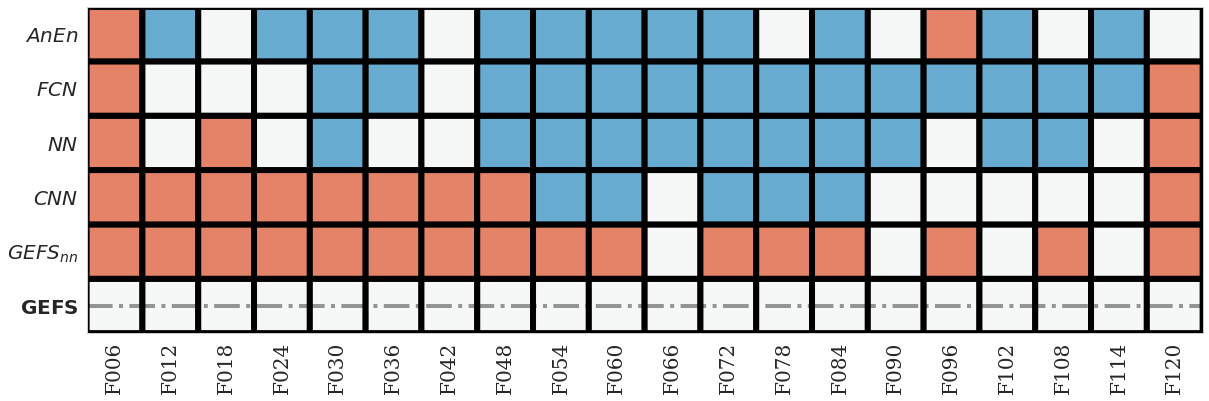

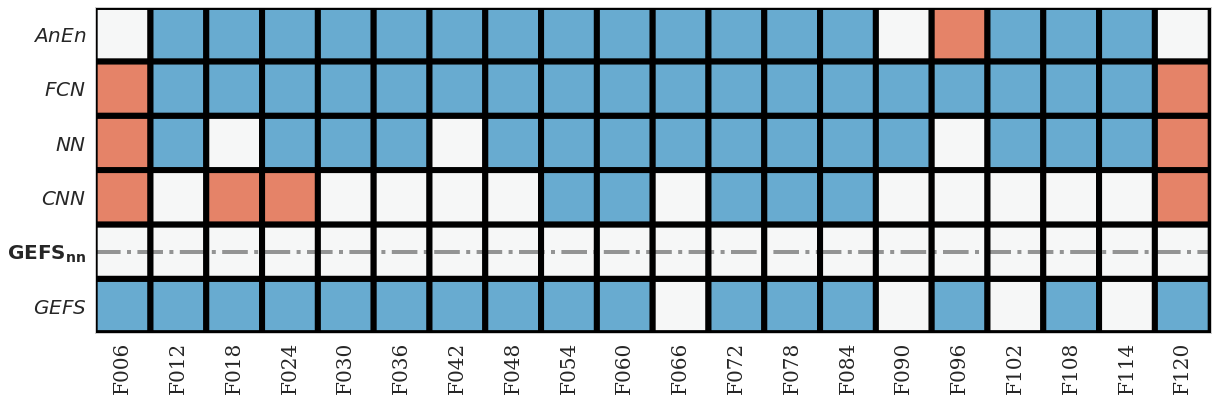

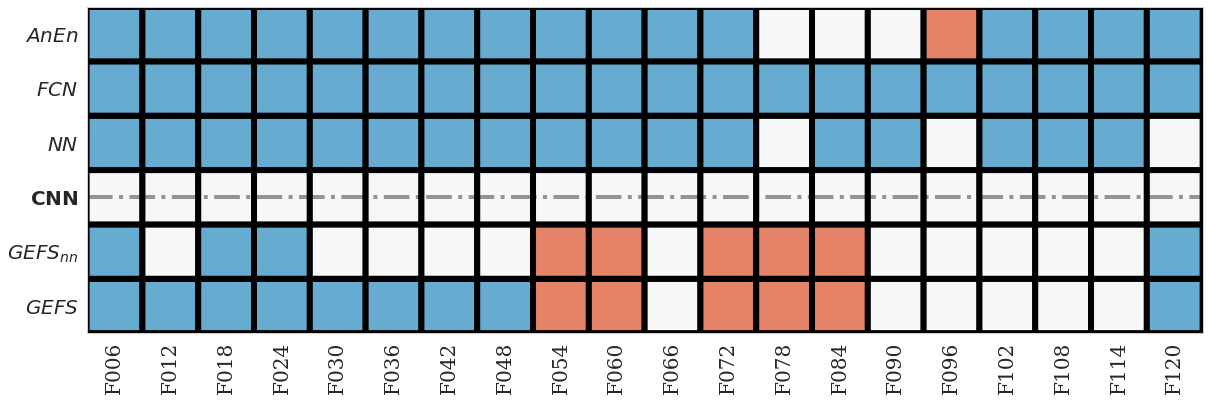

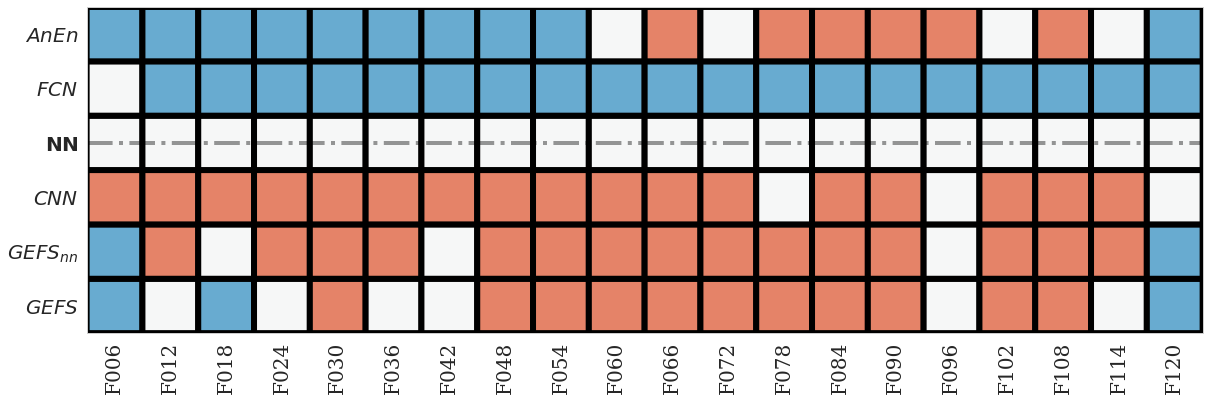

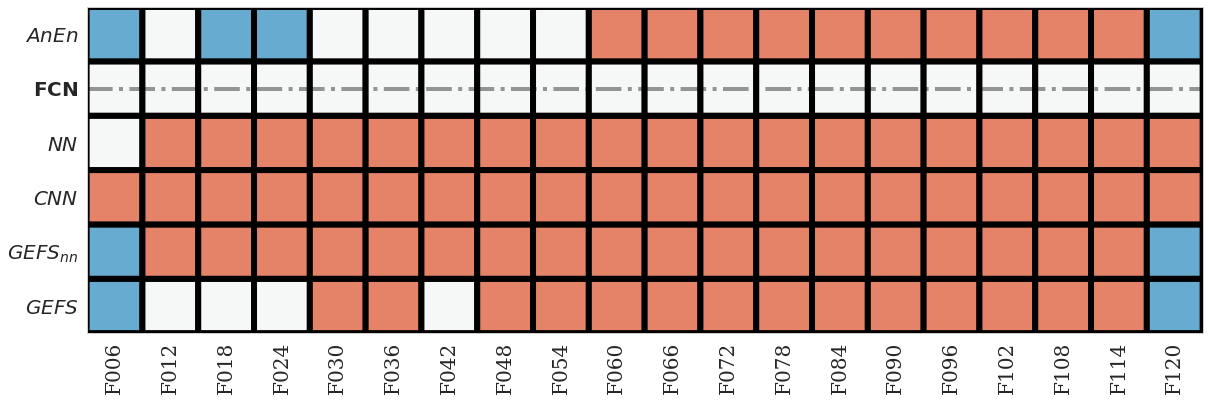

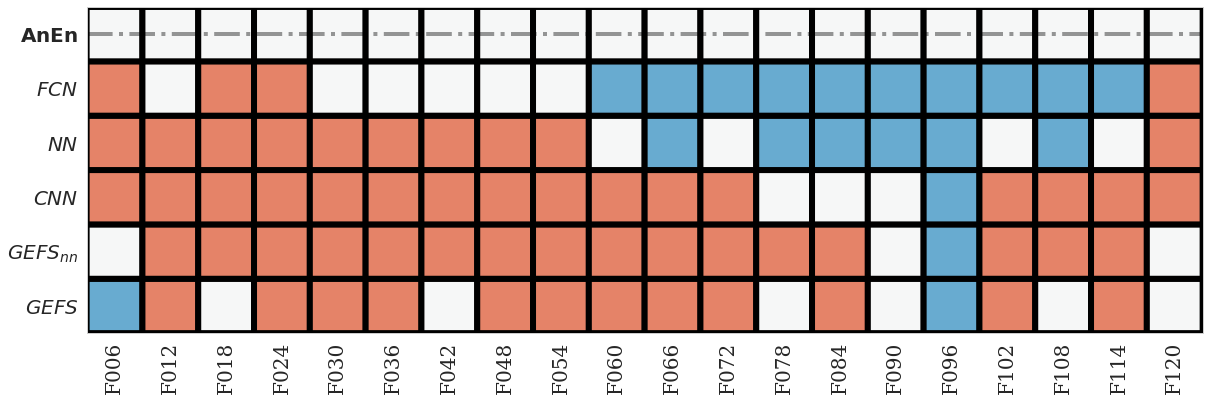

In [44]:
fnnnams= ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$AnEn$']
fnams = [['$\mathbf{GEFS}$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$AnEn$'],
         ['$GEFS$','$\mathbf{GEFS_{nn}}$','$CNN$','$NN$','$FCN$','$AnEn$'],
         ['$GEFS$','$GEFS_{nn}$','$\mathbf{CNN}$','$NN$','$FCN$','$AnEn$'],
         ['$GEFS$','$GEFS_{nn}$','$CNN$','$\mathbf{NN}$','$FCN$','$AnEn$'],
         ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$\mathbf{FCN}$','$AnEn$'],
         ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$\mathbf{AnEn}$']]


for Fnum in range(0,6):
    plotter = copy.deepcopy(DMs_tot[:,Fnum,:6].squeeze().T)
    signif_ = copy.deepcopy(BHsigni[:,Fnum,:6].squeeze().T)

    plotter[(signif_ > 0.05)] =0
    plotter[(plotter>0) & (signif_ < 0.05)]=1
    plotter[(plotter<0) & (signif_ < 0.05)]=-1
    plotter=plotter*-1

    plt.figure(figsize=(20,6))
    s=plt.pcolor(plotter,cmap='RdBu',edgecolors='k', linewidths=6,vmin=-2,vmax=2)
    locs, labels = plt.xticks() 
    plt.xticks(np.arange(0.5,20,1),fcasts,rotation='vertical',fontsize=20)
    plt.xticks(np.arange(0.5,20,1),fcasts,rotation='vertical',fontsize=20)
    plt.yticks(np.arange(0.5,6,1),fnams[Fnum],fontsize=20)
#     plt.yticks([Fnum+.5],[fnams[Fnum]])
    plt.plot([0,20],[Fnum+0.5,Fnum+0.5],'k',linestyle='-.',linewidth=4,alpha=0.4)
    plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/DMtest_FINAL_'+fnnnams[Fnum]+'_'+str(percy)+'_'+'_labels.png',dpi = 300,bbox_inches='tight')
    plt.show()

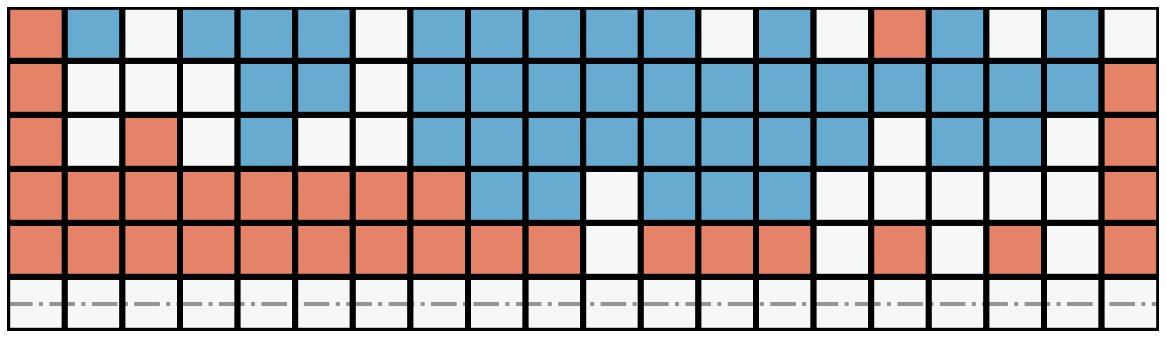

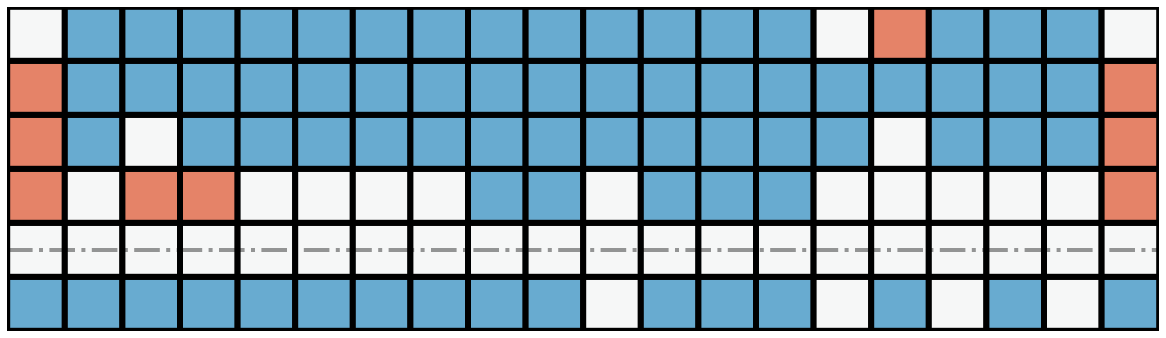

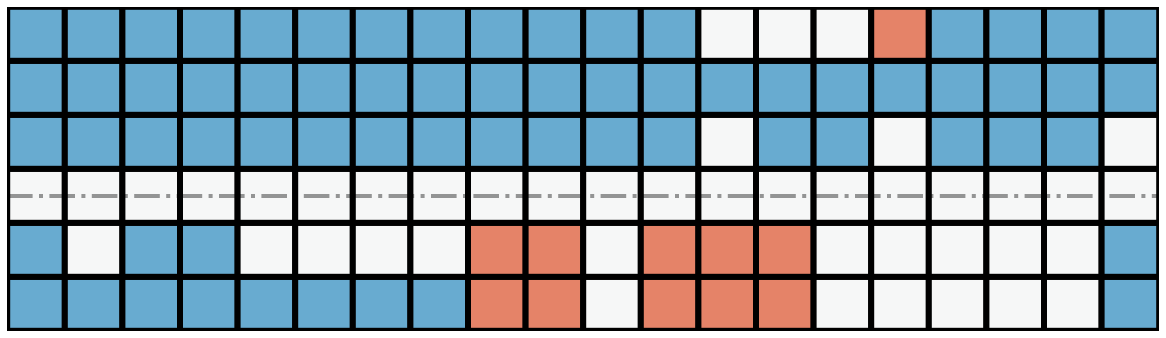

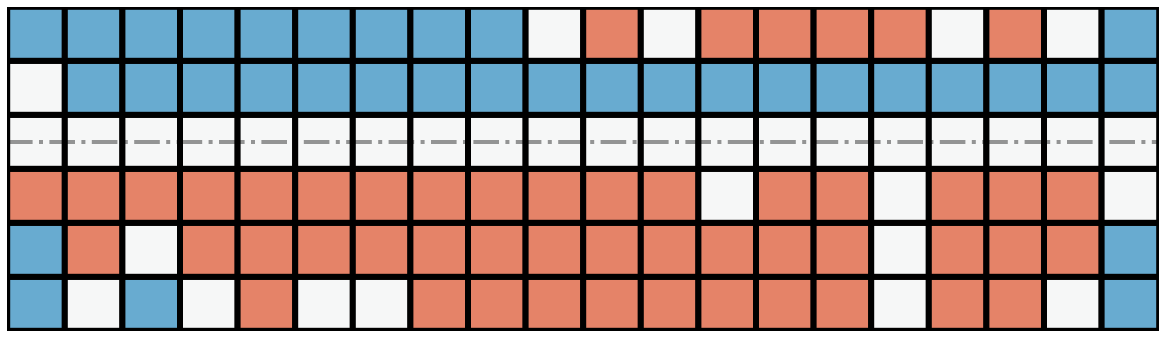

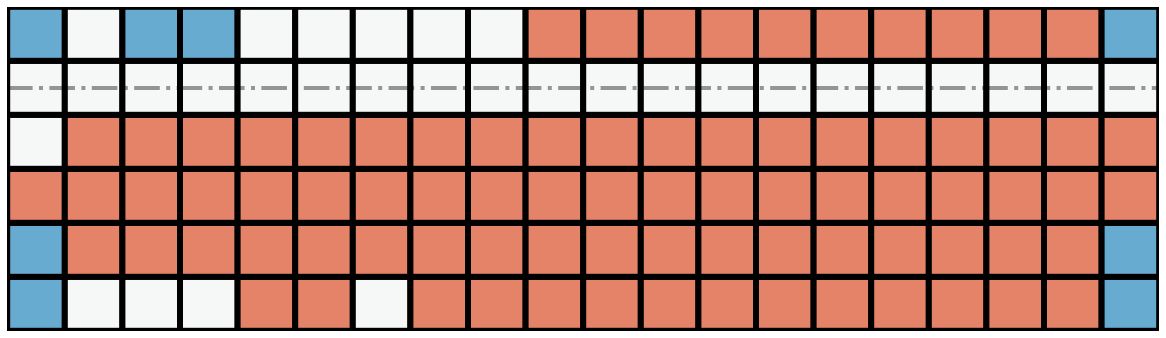

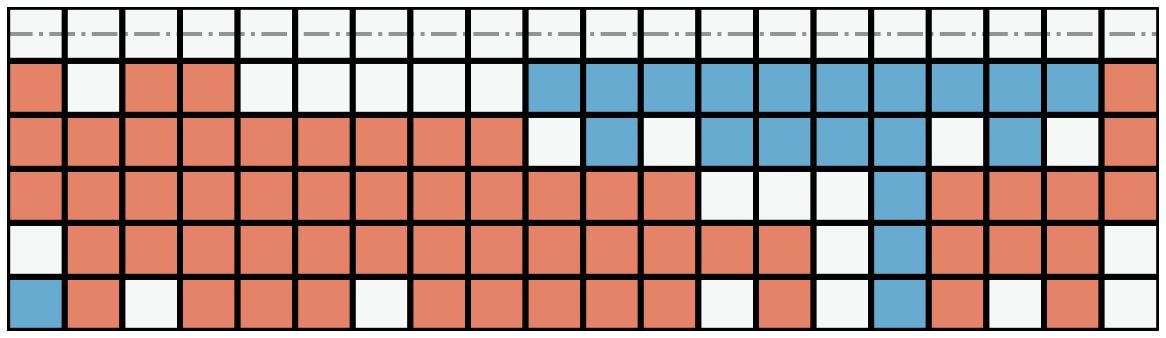

In [45]:
fnnnams= ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$AnEn$']
fnams = [['$\mathbf{GEFS}$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$AnEn$'],
         ['$GEFS$','$\mathbf{GEFS_{nn}}$','$CNN$','$NN$','$FCN$','$AnEn$'],
         ['$GEFS$','$GEFS_{nn}$','$\mathbf{CNN}$','$NN$','$FCN$','$AnEn$'],
         ['$GEFS$','$GEFS_{nn}$','$CNN$','$\mathbf{NN}$','$FCN$','$AnEn$'],
         ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$\mathbf{FCN}$','$AnEn$'],
         ['$GEFS$','$GEFS_{nn}$','$CNN$','$NN$','$FCN$','$\mathbf{AnEn}$']]
xinch =10
yinch =10

for Fnum in range(0,6):
    plotter = copy.deepcopy(DMs_tot[:,Fnum,:6].squeeze().T)
    sigger = copy.deepcopy(DMp_tot[:,Fnum,:6].squeeze().T)

    plotter[(sigger > 0.05)] =0
    plotter[(plotter>0) & (sigger < 0.05)]=1
    plotter[(plotter<0) & (sigger < 0.05)]=-1
    plotter=plotter*-1
    fig = plt.figure(figsize=(16,4.5))
    ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])
    ax.pcolor(plotter,cmap='RdBu',edgecolors='k', linewidths=6,vmin=-2,vmax=2)

    locs, labels = plt.xticks() 
    plt.xticks(np.arange(0.5,20,1),fcasts,rotation='vertical',fontsize=20)
    plt.xticks([], [])
    plt.yticks(np.arange(0.5,6,1),fnams[Fnum],fontsize=20)
    plt.yticks([],[])
#     plt.yticks([Fnum+.5],[fnams[Fnum]])
    plt.plot([0,20],[Fnum+0.5,Fnum+0.5],'k',linestyle='-.',linewidth=4,alpha=0.4)
    plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/DMtest_FINAL_'+fnnnams[Fnum]+'_'+str(percy)+'_'+'_NO_labels.png',dpi = 300,bbox_inches='tight')
    plt.show()

In [6]:
f1 = np.reshape(CRPS_gll,[CRPS_gll.shape[0]*CRPS_gll.shape[1],-1],order='F')
f2 = np.reshape(CRPS_nngll,[CRPS_nngll.shape[0]*CRPS_nngll.shape[1],-1],order='F')
f3 = np.reshape(CRPS_cll,[CRPS_cll.shape[0]*CRPS_cll.shape[1],-1],order='F')
f4 = np.reshape(CRPS_nll,[CRPS_nll.shape[0]*CRPS_nll.shape[1],-1],order='F')
f5 = np.reshape(CRPS_all,[CRPS_all.shape[0]*CRPS_all.shape[1],-1],order='F')
f6 = np.reshape(CRPS_mvll,[CRPS_mvll.shape[0]*CRPS_mvll.shape[1],-1],order='F')
CRPSS = np.stack([f1,f2,f3,f4,f5,f6]).squeeze()

In [24]:
DMtest(f4,f5,h=1,power=2,alternative='two.sided')

{'DM': 6.575936647205411,
 'forecast_horizon': 1,
 'power': 2,
 'p_val': 4.880957975698354e-11,
 'Method': 'Diebold-Mariano Test'}

In [25]:
np.mean(f4)

5.580004434845961

In [26]:
np.mean(f5)

5.80786911117772

In [29]:
np.nanmean(np.abs(f4)**2 - np.abs(f5)**2)

35.86796339594554

In [10]:
DMp

array([[0.   , 0.   , 0.211, 0.   , 0.004, 0.   ],
       [0.   , 0.   , 0.002, 0.   , 0.   , 0.002],
       [0.211, 0.002, 0.   , 0.   , 0.01 , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.004, 0.   , 0.01 , 0.   , 0.   , 0.   ],
       [0.   , 0.002, 0.   , 0.   , 0.   , 0.   ]])

In [68]:
Dtt = DMtest(f2,f1,h=2,power=2,alternative='two.sided')
Dtt

{'DM': -3.1981635850684107,
 'forecast_horizon': 2,
 'power': 2,
 'p_val': 0.001383895742020817,
 'Method': 'Diebold-Mariano Test'}

In [388]:
Dtt = DMtest(f1,f3,h=1,power=2,alternative='two.sided')
Dtt

{'DM': 9.56536102716294,
 'forecast_horizon': 1,
 'power': 2,
 'p_val': 1.1655396523106758e-21,
 'Method': 'Diebold-Mariano Test'}

In [13]:
np.arange(6,120,6)

array([  6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,  78,
        84,  90,  96, 102, 108, 114])

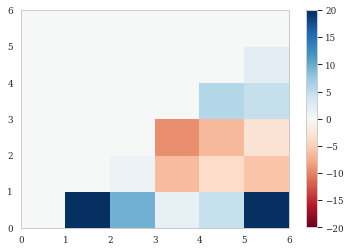

In [358]:
plt.pcolor(DMs,cmap='RdBu',vmin=-20,vmax=20)
plt.colorbar()

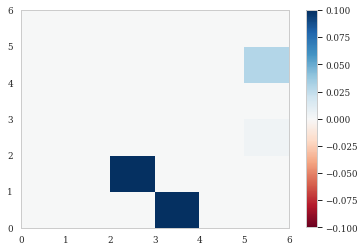

In [354]:
plt.pcolor(DMp,cmap='RdBu',vmin=-0.1,vmax=0.1)
plt.colorbar()

In [270]:
DMp

array([[0.        , 0.00492821, 0.28298868, 0.46088544, 0.41827675,
        0.03194689],
       [0.        , 0.        , 0.42869693, 0.32881125, 0.31760554,
        0.29333293],
       [0.        , 0.        , 0.        , 0.3095728 , 0.27127978,
        0.43711337],
       [0.        , 0.        , 0.        , 0.        , 0.40828298,
        0.40864184],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.40209559],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [227]:
DMpval=0
DMtot=0
for gg in range(CRPSS.shape[2]):            
    Dtt = DMtest(CRPS_gll[:,gg],CRPS_nngll[:,gg],h=1,power=2,alternative='two.sided')
    DMtot+=Dtt['DM']
    DMpval+=Dtt['p_val']
#     print(Dtt['DM'])
#     print(Dtt['p_val'])
                
print(np.round(DMtot/CRPSS.shape[2],3))
print(DMpval/CRPSS.shape[2])

0.936
0.3154884879288985


In [235]:
DMp

array([[0.        , 0.18008022, 0.4226163 , 0.42871692, 0.47330034,
        0.17840102],
       [0.        , 0.        , 0.4915359 , 0.26741863, 0.3102398 ,
        0.4060804 ],
       [0.        , 0.        , 0.        , 0.17339845, 0.2257577 ,
        0.4551275 ],
       [0.        , 0.        , 0.        , 0.        , 0.39371076,
        0.3331614 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.35035331],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

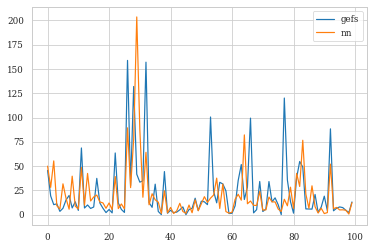

In [246]:
plt.plot(CRPS_gll[100:200,gg],label='gefs')
plt.plot(CRPS_nll[100:200,gg],label='nn')
plt.legend()


In [419]:
def DMtest(e1,e2,h=1,power=2,alternative='two.sided'):
    d = np.abs(e1)**power - np.abs(e2)**power
    dcov = acovf(d,nlag=h-1,fft=False,missing='drop')
    dvar = np.sum(np.append(dcov[0],2*dcov[1:]))/len(d)
    dv = dvar
#     print('dmean:',np.nanmean(d))
#     print('dvar:',dvar)
    if dv>0:
        STATISTIC =np.nanmean(d)/np.sqrt(dv)
    elif (h==1):
        raise ValueError("Variance of DM statistic is zero")
    else: 
        warnings.warn('Variance is negative, using horizon h=1') 
        DMtest(e1,e2,h=1,power=power)   
    n = len(d)
    k = ((n + 1 - 2 * h + (h / n) * (h - 1)) / n) **(0.5)
    STATISTIC = STATISTIC *k 
    
    if alternative == 'two.sided':
        PVAL = 2*stats.t.cdf(-np.abs(STATISTIC),df=n-1)
    elif alternative == 'less':
        PVAL = stats.t.cdf(STATISTIC,df=n-1)
    elif alternative == 'greater':
        PVAL = 1-stats.t.cdf(STATISTIC,df=n-1)
        
    PARAMETER = [h,power]
    return_DICT = {"DM":STATISTIC,'forecast_horizon':h,'power':power,'p_val':PVAL,'Method':'Diebold-Mariano Test'
                  }
    return return_DICT


In [335]:
Dtt = DMtest(f1,f2,h=1,power=2,alternative='two.sided')
Dtt

dvar: 3.6005804810707844


{'DM': 22.4927230844165,
 'forecast_horizon': 1,
 'power': 2,
 'p_val': 1.6925647036895134e-111,
 'Method': 'Diebold-Mariano Test'}

In [334]:
f1 = np.reshape(CRPS_gll,[357*144,-1],order='F')
f2 = np.reshape(CRPS_nngll,[357*144,-1],order='F')

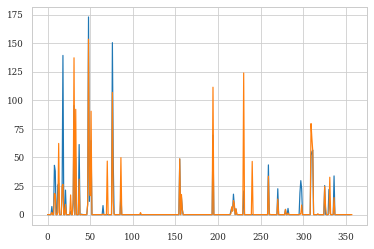

In [332]:
plt.plot(f1[1:357])
plt.plot(f1[358:358*2])

In [346]:
f1 = np.reshape(CRPS_gll,[CRPS_gll.shape[0]*CRPS_gll.shape[1],-1],order='F')
f2 = np.reshape(CRPS_nngll,[CRPS_nngll.shape[0]*CRPS_nngll.shape[1],-1],order='F')
f3 = np.reshape(CRPS_cll,[CRPS_cll.shape[0]*CRPS_cll.shape[1],-1],order='F')
f4 = np.reshape(CRPS_nll,[CRPS_nll.shape[0]*CRPS_nll.shape[1],-1],order='F')
f5 = np.reshape(CRPS_all,[CRPS_all.shape[0]*CRPS_all.shape[1],-1],order='F')
f6 = np.reshape(CRPS_mvll,[CRPS_mvll.shape[0]*CRPS_mvll.shape[1],-1],order='F')
CRPSS = np.stack([f1,f2,f3,f4,f5,f6]).squeeze()

In [368]:
DMtest(f1,f5,h=1,power=2,alternative='two.sided')

{'DM': 4.60775882243628,
 'forecast_horizon': 1,
 'power': 2,
 'p_val': 4.080082049553134e-06,
 'Method': 'Diebold-Mariano Test'}

In [357]:
DMs

array([[ 0.   , 23.659,  9.565,  1.639,  4.608, 23.107],
       [ 0.   ,  0.   ,  1.188, -6.297, -3.804, -5.669],
       [ 0.   ,  0.   ,  0.   , -9.231, -6.426, -2.895],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  5.88 ,  4.749],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  2.186],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [ ]:
percys = [0]
for percy in percys:
    
    dffin=pd.DataFrame({'Lead':[],'Model':[],'CRPS':[]})
    fcasts = ['F'+f'{bb:03}' for bb in np.arange(0,126,12)]
    fcasts = ['F'+f'{bb:03}' for bb in np.arange(24,36,12)]
    ense = 100

    for fcast in fcasts:
        print('doing:',fcast)
        fortts=np.array([])
        mods = ['CNNft_ref','MV_gefs','Raw_gefs','AnEn','NN_ref']
        for mod in mods:
            df,Pre_m, Pre_s, Post_m, Post_s, Obs =utils_verif.load_forecast(fcast,mod)
            fortts=np.concatenate([fortts,np.array(Post_m)])
            bounds =[]
#             threshold = np.percentile(fortts,percy)
            threshold=percy
        ##############
        print("this is the threshold:",threshold,'for a percentile:', percy)
        ########################################################################################################
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnng','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})
    
        mod = 'CNNft_ref'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast_cnn','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
        df2['lon']=df2['lon']+360
    
        mod = 'NNft_ref'
        df3,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df3 = df3.rename(columns={'OBS':'OBSnn','Model':'Reforecast_nn','IVTmean':'IVTmean_nn','IVTstd':'IVTstd_nn'})
        df3['lon']=df3['lon']+360
    
    
        mod = 'AnEn'
        df4,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df4 = df4.rename(columns={'OBS':'OBSanen','Model':'Reforecast_AnEn','IVTmean':'IVTmean_anen','IVTstd':'IVTstd_anen'})
        df4['AnEn_Mean'] = np.mean(df4.filter(regex='Analog'),axis=1)
        df4['AnEn_std'] = np.std(df4.filter(regex='Analog'),axis=1)
        df4['time']= df4['Issued_Time']+ timedelta(hours=int(fcast[-3:]))
    
        mod = 'NN_gefs'
        df5,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df5 = df5.rename(columns={'OBS':'OBSnng','Model':'Reforecast','IVTmean':'IVTmean_nngefs','IVTstd':'IVTstd_nngefs'})
        
        mod = 'MV_gefs'
        df6,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df6 = df6.rename(columns={'OBS':'OBSnng','Model':'Reforecast','IVTmean':'IVTmean_mvgefs','IVTstd':'IVTstd_mvgefs'})


        dfm = pd.merge(df1,df2,how='left')
        dfm = pd.merge(dfm,df3,how='left')
        dfm = pd.merge(dfm,df4,how='left')
        dfm = pd.merge(dfm,df5,how='left')
        dfm = pd.merge(dfm,df6,how='left')
    
    
        #define 4 groups:
        Merrag = dfm['OBSnng']
        For_ug = dfm['IVTmean_gefs']
        For_sg = dfm['IVTstd_gefs']
    
        Merranng = dfm['OBSnng']
        For_unng = dfm['IVTmean_nngefs']
        For_snng = dfm['IVTstd_nngefs']
    
        Merrac = dfm['OBScnn']
        For_uc = dfm['IVTmean_cnn']
        For_sc = dfm['IVTstd_cnn']
    
        Merran = dfm['OBSnn']
        For_un = dfm['IVTmean_nn']
        For_sn = dfm['IVTstd_nn']
    
        Merraa = dfm['OBSanen']
        For_ua = dfm['AnEn_Mean']
        For_sa = dfm['AnEn_std']
        
        Merramvg = dfm['OBSnng']
        For_umvg = dfm['IVTmean_mvgefs']
        For_smvg = dfm['IVTstd_mvgefs']
        
        
        countstats = 0 
        CRPS_gll=np.zeros([357,144])
        CRPS_nngll=np.zeros([357,144])
        CRPS_cll=np.zeros([357,144])
        CRPS_nll=np.zeros([357,144])
        CRPS_all=np.zeros([357,144])
        CRPS_mvll=np.zeros([357,144])
        for lats in np.unique(dfm['lat']):
            for lons in np.unique(dfm['lon']):
                dftemp = dfm[(dfm['lat']==lats)&(dfm['lon']==lons)]
                countstats+=1
                if dftemp.shape[0] == 0:
                    countstats-=1
                    continue
            
                 #define 4 groups:
                Merrag = dftemp['OBSnng'].reset_index(drop=True)
                For_ug = dftemp['IVTmean_gefs'].reset_index(drop=True)
                For_sg = dftemp['IVTstd_gefs'].reset_index(drop=True)
    
                Merranng = dftemp['OBSnng'].reset_index(drop=True)
                For_unng = dftemp['IVTmean_nngefs'].reset_index(drop=True)
                For_snng = dftemp['IVTstd_nngefs'].reset_index(drop=True)
    
                Merrac = dftemp['OBScnn'].reset_index(drop=True)
                For_uc = dftemp['IVTmean_cnn'].reset_index(drop=True)
                For_sc = dftemp['IVTstd_cnn'].reset_index(drop=True)
    
                Merran = dftemp['OBSnn'].reset_index(drop=True)
                For_un = dftemp['IVTmean_nn'].reset_index(drop=True)
                For_sn = dftemp['IVTstd_nn'].reset_index(drop=True)
    
                Merraa = dftemp['OBSanen'].reset_index(drop=True)
                For_ua = dftemp['AnEn_Mean'].reset_index(drop=True)
                For_sa = dftemp['AnEn_std'].reset_index(drop=True)
        
                Merramvg = dftemp['OBSnng'].reset_index(drop=True)
                For_umvg = dftemp['IVTmean_mvgefs'].reset_index(drop=True)
                For_smvg = dftemp['IVTstd_mvgefs'].reset_index(drop=True)
                


                #aadefine 4 groups:
                Ensemblg = np.zeros([Merrag.shape[0],ense])
                Truthg = np.zeros([Merrag.shape[0]])
                Ensemblc = np.zeros([Merrag.shape[0],ense])
                Truthc = np.zeros([Merrag.shape[0]])
                Ensembln = np.zeros([Merran.shape[0],ense])
                Truthn = np.zeros([Merran.shape[0]])    
                Ensembla = np.zeros([Merraa.shape[0],ense])
                Trutha = np.zeros([Merraa.shape[0]])
                Ensemblnng = np.zeros([Merrag.shape[0],ense])
                Truthnng = np.zeros([Merrag.shape[0]])
                Ensemblmvg = np.zeros([Merrag.shape[0],ense])
                Truthmvg = np.zeros([Merrag.shape[0]])
        
        
                for gre in range(Merrag.shape[0]):
                    Ensemblg[gre,:]=np.random.normal(For_ug[gre],For_sg[gre],100)
                    Truthg[gre] = Merrag[gre]
                    Ensemblc[gre,:]=np.random.normal(For_uc[gre],For_sc[gre],100)
                    Truthc[gre] = Merrac[gre]
                    Ensembln[gre,:]=np.random.normal(For_un[gre],For_sn[gre],100)
                    Truthn[gre] = Merran[gre]
                    Ensembla[gre,:]=np.random.normal(For_ua[gre],For_sa[gre],100)
                    Trutha[gre] = Merraa[gre]
                    Ensemblnng[gre,:]=np.random.normal(For_unng[gre],For_snng[gre],100)
                    Truthnng[gre] = Merranng[gre]
                    Ensemblmvg[gre,:]=np.random.normal(For_umvg[gre],For_smvg[gre],100)
                    Truthmvg[gre] = Merramvg[gre]

    
                CRPStempg = np.zeros((Merrag.shape[0]))
                CRPStempnng = np.zeros((Merranng.shape[0]))
                CRPStempmvg = np.zeros((Merramvg.shape[0]))
                CRPStempc = np.zeros((Merrac.shape[0]))
                CRPStempn = np.zeros((Merran.shape[0]))
                CRPStempa = np.zeros((Merraa.shape[0]))

    
                for gre in range(0,Merrac.shape[0]):    
                    if np.max(np.append(Merrac[gre],Ensemblc[gre,:]))<=threshold:
                        CRPStempc[gre] = 0
                    else:
                        CRPStempc[gre] = twcrps_sample2(Merrac[gre],Ensemblc[gre,:],'indicator.right',threshold,step_width=10)


                for gre in range(0,Merrag.shape[0]):    
                    if np.max(np.append(Merrag[gre],Ensemblg[gre,:]))<=threshold:
                        CRPStempg[gre] = 0
                    else:
                        CRPStempg[gre] = twcrps_sample2(Merrag[gre],Ensemblg[gre,:],'indicator.right',threshold,step_width=10)

     
                for gre in range(0,Merran.shape[0]):    
                    if np.max(np.append(Merran[gre],Ensembln[gre,:]))<=threshold:
                        CRPStempn[gre] = 0
                    else:
                        CRPStempn[gre] = twcrps_sample2(Merran[gre],Ensembln[gre,:],'indicator.right',threshold,step_width=10)


                for gre in range(0,Merraa.shape[0]):    
                    if np.max(np.append(Merraa[gre],Ensembla[gre,:]))<=threshold:
                        CRPStempa[gre] = 0
                    else:
                        CRPStempa[gre] = twcrps_sample2(Merraa[gre],Ensembla[gre,:],'indicator.right',threshold,step_width=10)
            
                for gre in range(0,Merraa.shape[0]):    
                    if np.max(np.append(Merranng[gre],Ensemblnng[gre,:]))<=threshold:
                        CRPStempnng[gre] = 0
                    else:
                        CRPStempnng[gre] = twcrps_sample2(Merranng[gre],Ensemblnng[gre,:],'indicator.right',threshold,step_width=10)
                                
                for gre in range(0,Merraa.shape[0]):    
                    if np.max(np.append(Merramvg[gre],Ensemblmvg[gre,:]))<=threshold:
                        CRPStempmvg[gre] = 0
                    else:
                        CRPStempmvg[gre] = twcrps_sample2(Merramvg[gre],Ensemblmvg[gre,:],'indicator.right',threshold,step_width=10)
                     
                CRPS_gll[:,countstats-1] = CRPStempg
                CRPS_nngll[:,countstats-1] = CRPStempnng
                CRPS_cll[:,countstats-1] = CRPStempc
                CRPS_nll[:,countstats-1] = CRPStempn
                CRPS_all[:,countstats-1] = CRPStempa
                CRPS_mvll[:,countstats-1] = CRPStempmvg
                
                CRPSS = np.stack([CRPS_gll,CRPS_nngll,CRPS_cll,CRPS_nll,CRPS_all,CRPS_mvll])
                
        print('___ ...done... Starting DM ___')      
        DMs = np.zeros([6,6])
        DMp = np.zeros([6,6])
        for ii in range(0,6):
            for jj in range(0,6):
                DMtot = 0
                DMpval = 0
                if ii == jj:
                    continue
                for gg in range(CRPSS.shape[2]):
                    
                    Dtt = DMtest(CRPSS[ii,:,gg],CRPSS[jj,:,gg],h=1,power=2,alternative='two.sided')
                    DMtot+=Dtt['DM']
                    DMpval+=Dtt['p_val']
                
                DMs[ii,jj] = np.round(DMtot/CRPSS.shape[2],3)
                DMp[ii,jj] = DMpval/CRPSS.shape[2]
                
                DMs = np.triu(DMs, k=0)
                DMp = np.triu(DMp, k=0)
#         CRPS_gll=np.mean(CRPS_gll)
#         CRPS_nngll=np.mean(CRPS_nngll)
#         CRPS_cll= np.mean(CRPS_cll)
#         CRPS_nll= np.mean(CRPS_nll)
#         CRPS_all= np.mean(CRPS_all)
#         CRPS_mvll= np.mean(CRPS_mvll)  
        
#         DMs = np.zeros([6,6])
        
#         for ii in range(0,6):
#             for jj in range(0,6):
#                 DMS[ii,jj] = 
    
#         print("...boostrapping....")
# #     bootstrap randomdraws:
#         CRPScnn_ref = np.zeros(bsnummy)
#         CRPSnn_ref = np.zeros(bsnummy)
#         CRPSanen_ref = np.zeros(bsnummy)
#         CRPSnng_gefs = np.zeros(bsnummy)
#         CRPSmvg_gefs = np.zeros(bsnummy)
        
                                
                                
    
#         for bb in range(bsnummy):
#             inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])
#             CRPScnn_ref[bb] = (1 - (np.mean(CRPStempc[inss])/np.mean(CRPStempg[inss])))*100
#             CRPSnn_ref[bb] = (1 - (np.mean(CRPStempn[inss])/np.mean(CRPStempg[inss])))*100
#             CRPSanen_ref[bb] = (1 - (np.mean(CRPStempa[inss])/np.mean(CRPStempg[inss])))*100
#             CRPSnng_gefs[bb] = (1 - (np.mean(CRPStempnng[inss])/np.mean(CRPStempg[inss])))*100
#             CRPSmvg_gefs[bb] = (1 - (np.mean(CRPStempmvg[inss])/np.mean(CRPStempg[inss])))*100
        
#         #define 3 groups:  
#         dftemp = pd.DataFrame({'CRPS':CRPSnng_gefs})
#         dftemp['Lead'] = fcast
#         dftemp['Model'] = 'NN_gefs'
#         dffin = pd.concat([dffin, dftemp], axis=0)
        
# #         dftemp = pd.DataFrame({'CRPS':CRPSmvg_gefs})
# #         dftemp['Lead'] = fcast
# #         dftemp['Model'] = 'MV_gefs'
# #         dffin = pd.concat([dffin, dftemp], axis=0)
    
#         dftemp = pd.DataFrame({'CRPS':CRPScnn_ref})
#         dftemp['Lead'] = fcast
#         dftemp['Model'] = 'CNN_ref'
#         dffin = pd.concat([dffin, dftemp], axis=0)
    
#         dftemp = pd.DataFrame({'CRPS':CRPSnn_ref})
#         dftemp['Lead'] = fcast
#         dftemp['Model'] = 'NN_ref'
#         dffin = pd.concat([dffin, dftemp], axis=0)
    
#         dftemp = pd.DataFrame({'CRPS':CRPSanen_ref})
#         dftemp['Lead'] = fcast
#         dftemp['Model'] = 'AnEn'
#         dffin = pd.concat([dffin, dftemp], axis=0)
        
#         print('...done...')
    
    
#     plt.figure(figsize=BPdict['FigSize'])
#     plt.plot([-10,23],[0,0],'k')

#     ax = sns.boxplot(x="Lead", y="CRPS", hue="Model",data=dffin, palette=mycolors,whis=[10, 90])
#     plt.yticks(fontsize=BPdict['tickFS'])
#     plt.xticks(fontsize=BPdict['tickFS'])
#     plt.ylabel('[%]',fontsize=BPdict['labelFS'])
#     plt.xlabel('Lead',fontsize=BPdict['labelFS'])
# #     plt.legend(fontsize=BPdict['legendFS'],loc='upper right')
#     ax.get_legend().remove()
#     plt.title('twCRPS',fontsize=BPdict['titleFS'])

#     for bb in np.arange(-0.5,22,1):
#         plt.plot([bb,bb],[-20,25],'k--')

#     plt.ylim([-15,21])
#     plt.xlim([-0.5,10.5])
#     plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/TWCRPS_threshold_no_legend_'+str(percy)+'.png',dpi = 300,bbox_inches='tight')

#     plt.show()